In [1]:
import dowhy
from IPython.core.display_functions import display
from dowhy import CausalModel
# from rpy2.robjects import r as R
# %load_ext rpy2.ipython
import numpy as np
import pandas as pd
import graphviz
import networkx as nx


def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d


def str_to_dot(string):
    '''
    Converts input string from graphviz library to valid DOT graph format.
    '''
    graph = string.replace('\n', ';').replace('\t', '')
    graph = graph[:9] + graph[10:-2] + graph[-1]  # Removing unnecessary characters from string
    return graph


df = pd.read_csv("../data/data.csv")
# # df.dropna(subset=["AGE", "SYSBP", "DIABP", "CURSMOKE", "BPMEDS", "CVD"], inplace=True)
#
# ids = df[df["BPMEDS"].isnull()]["RANDID"]
# for i in ids:
#     if df[df["RANDID"] == i]["RANDID"].count() == 1:
#         print(df[df["RANDID"] == i]["RANDID"])
# df = df[~df.RANDID.isin([481202, 797308, 2286129, 4668307, 4669258, 4990326, 5524196, 7935008])]
# # Remove subjects that only have one observation but have missing data.
# ids = df[df["BPMEDS"].isnull()]["RANDID"]
# for i in ids:
#     value = df[df["RANDID"] == i]["BPMEDS"].max()
#     df.loc[df["RANDID"] == i, "BPMEDS"] = df[df["RANDID"] == i]["BPMEDS"].fillna(value=value)
df = df[["RANDID", "AGE", "SYSBP", "DIABP", "CURSMOKE", "BPMEDS", "CVD","TOTCHOL", "BMI", "HEARTRTE", "GLUCOSE","educ"]]
df = df.groupby(['RANDID']).aggregate(
    {'AGE': np.average, 'SYSBP': np.average, 'DIABP': np.average, 'CURSMOKE': np.max, 'BPMEDS': np.max, 'CVD': np.max, "TOTCHOL":np.average, "BMI":np.average, "HEARTRTE":np.average, "GLUCOSE":np.average, "educ":np.max})
df = df.dropna()
df["BPMEDS"] = df["BPMEDS"].astype(int)
df['AGE'] = df['AGE'].astype(int)
df['SYSBP'] = df['SYSBP'].astype(int)
df['DIABP'] = df['DIABP'].astype(int)
df['educ'] = df['educ'].astype(int)
df['HEARTRTE'] = df['HEARTRTE'].astype(int)
df['GLUCOSE'] = df['GLUCOSE'].astype(int)
print(df.head())

        AGE  SYSBP  DIABP  CURSMOKE  BPMEDS  CVD  TOTCHOL        BMI  \
RANDID                                                                 
6238     52    111     72         0       0    0    249.0  28.886667   
9428     51    134     84         1       0    0    264.0  25.340000   
10552    64    166    102         1       0    1    228.5  29.380000   
11263    49    179    106         0       1    1    226.0  30.943333   
12629    66    143     76         0       0    0    212.5  34.935000   

        HEARTRTE  GLUCOSE  educ  
RANDID                           
6238          85       77     2  
9428          75       78     1  
10552         62       96     3  
11263         94       88     2  
12629         70       91     1  


No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


Method : LiNGAM


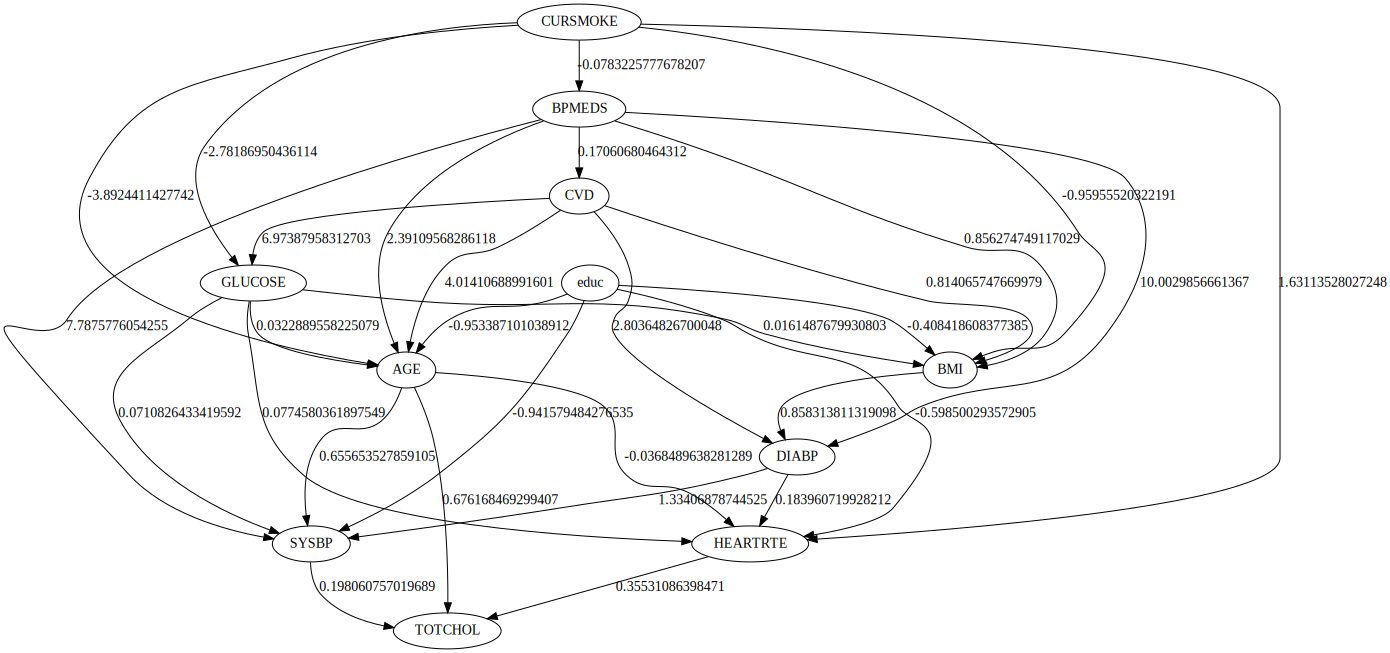

Method : PC


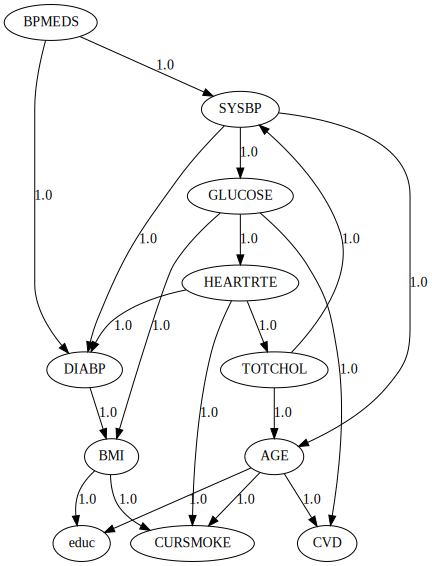

Method : GES


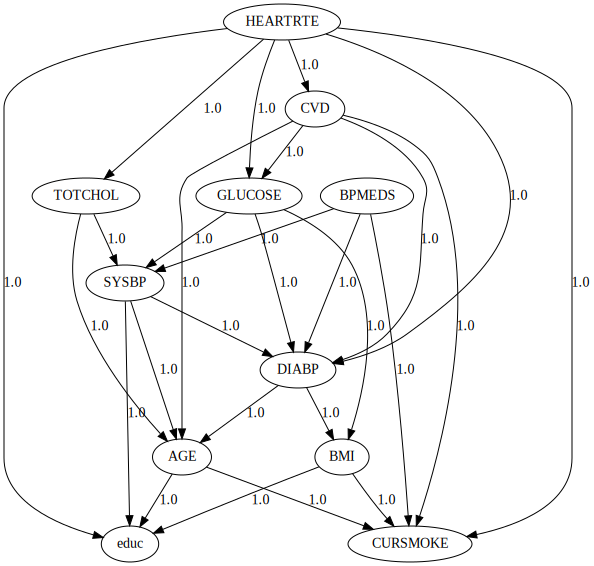

In [2]:
import cdt
from cdt.causality.graph import LiNGAM, PC, GES

cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.1.2/bin/Rscript'
graphs = {}
labels = [f'{col}' for i, col in enumerate(df.columns)]
functions = {
    'LiNGAM': LiNGAM,
    'PC': PC,
    'GES': GES,
}

for method, lib in functions.items():
    obj = lib()
    output = obj.predict(df)
    adj_matrix = nx.to_numpy_matrix(output)
    adj_matrix = np.asarray(adj_matrix)
    graph_dot = make_graph(adj_matrix, labels)
    graphs[method] = graph_dot

# Visualize graphs
for method, graph in graphs.items():
    print("Method : %s" % method)
    display(graph)